# Парето-оптимальность, Selenium и отели в Пекине

Название [моего блога](https://vk.com/mat.chast) как бы намекает, что его содержание применимо в быту. К сегодняшнему блокноту это точно относится: он про выбор отелей. 

Моя подруга на новогодние праздники собралась в Пекин, и для этого решила выбрать отель. В Пекине их тысяча, и она ограничила поиск только пятизвёздочными. Но даже таких отелей там больше сотни, и из них хочется выбрать наилучший по соотношению цена-качество.

Сколько можно заплатить за дополнительный балл оценки (она измеряет качество)? На этот вопрос ответ у каждого свой. Но чтобы не перебирать вручную 150 отелей, можно заставить алгоритм отобрать с десяток отелей, каждый из которых был бы лучшим в своей ценовой категории. В математике такие отели называются Парето-оптимальными.

А раз уж мы всё равно пользуемся алгоритмом, почему бы не распарсить booking.com тоже полностью автоматически?

Именно этому - парсингу booking.com и выбору оптимального отеля - и посвящён блокнот. 

# Сбор данных при помощи Selenium

Предполагается, что:
* у вас установлены все необходимые питоновские пакеты. Если какой-то импорт не работает, зовите pip install
* у вас установлен Firefox (если не хотите его ставить, попробуйте другой бразуер, но к нему нужен свой драйвер)
* у вас есть geckodriver, скачанный отсюда https://github.com/mozilla/geckodriver/releases и распакованный
* этот geckodriver находится в той же папке, что и блокнот (либо добавлен в PATH)

Если вам лень заниматься всей этой технической частью, можете [скачать данные](https://github.com/avidale/weirdMath/blob/master/hotels.pkl) и сразу перейти к их анализу. 

Импортируем Селениум. Если эта ячейка выдаёт ошибку, вызовите pip install selenium в командной строке и перезапустите блокнот

In [1]:
from selenium import webdriver

Запускаем браузер в управляемом режиме. 

In [2]:
driver = webdriver.Firefox() 

Ниже - ссылка на запрос отеля в Пекине с ограничением на даты и звёздочки

In [3]:
url = "https://www.booking.com/searchresults.ru.html?label=gen173nr-1FCAEoggJCAlhYSDNYBGjCAYgBAZgBIcIBCndpbmRvd3MgMTDIAQzYAQHoAQH4AQuSAgF5qAID&sid=6b8e3d83b69499330279412a904e1bd4&checkin_month=1&checkin_monthday=4&checkin_year=2018&checkout_month=1&checkout_monthday=11&checkout_year=2018&class_interval=1&dest_id=-1898541&dest_type=city&dtdisc=0&from_sf=1&group_adults=2&group_children=0&inac=0&index_postcard=0&label_click=undef&no_rooms=1&oos_flag=0&postcard=0&room1=A%2CA&sb_price_type=total&search_pageview_id=2f838df472d401ec&src=index&ss=Пекин&ss_all=0&ssb=empty&sshis=0&nflt=class%3D5%3B&lsf=class%7C5%7C124&unchecked_filter=class"

Сейчас будет магия: открытый из кода браузер сам перейдёт по ссылке

In [4]:
driver.get(url)

Напишем функцию, которая бы находила внутри блока с отелем его название, рейтинг и цену

In [5]:
def get_data_from_hotel(div):
    name = div.find_elements_by_css_selector('span.sr-hotel__name')[0].text
    
    rating_elements =  div.find_elements_by_css_selector('span.review-score-badge')
    if rating_elements:
        rating = rating_elements[0].text
    else:
        rating = 0
    
    price_elements = price = div.find_elements_by_css_selector('strong.price')
    if price_elements:
        price = price_elements[0].text
    else:
        price = None
    
    hotel = {'name':name, 'price': price, 'rating': rating}
    return hotel

Теперь пройдёмся по всем 15 блокам с отелями и выкачаем цены. 

Для двух отелей цен нет: все комнаты уже забронировали.

In [6]:
hotels = []

In [7]:
for div in driver.find_elements_by_css_selector('div.sr_item'):
    hotel = get_data_from_hotel(div)
    print(hotel)
    hotels.append(hotel)

{'name': 'New World Beijing Hotel', 'price': '46 554 руб.', 'rating': '9,1'}
{'name': 'DoubleTree by Hilton Beijing', 'price': '35 153 руб.', 'rating': '7,5'}
{'name': 'Sofitel Wanda Beijing', 'price': '55 237 руб.', 'rating': '8,3'}
{'name': 'Ascott Raffles City Beijing', 'price': '69 792 руб.', 'rating': '8,8'}
{'name': 'Artyzen Habitat Dongzhimen Beijing', 'price': '43 488 руб.', 'rating': '8,5'}
{'name': 'Crowne Plaza Beijing Lido', 'price': '61 820 руб.', 'rating': '8,4'}
{'name': 'Hotel Éclat Beijing', 'price': '92 874 руб.', 'rating': '9,1'}
{'name': "W Beijing Chang'an", 'price': '85 549 руб.', 'rating': '8,5'}
{'name': 'Conrad Beijing', 'price': '57 686 руб.', 'rating': '8,4'}
{'name': 'The Ritz-Carlton Beijing', 'price': '106 825 руб.', 'rating': '8,8'}
{'name': 'DuGe Boutique Hotel', 'price': '50 307 руб.', 'rating': '7,9'}
{'name': 'JW Marriott Hotel Beijing', 'price': '82 878 руб.', 'rating': '8,3'}
{'name': 'Crowne Plaza Beijing Zhongguancun', 'price': '50 884 руб.', 'rat

Теперь всё то же самое проделаем для следующих нескольких страниц с отелями. 

Для этого заставим браузер находить кнопку "Следующая страница", жамкать на неё самостоятельно, и ждать 3 секунды, пока отели подгрузятся. 

Заодно будем печатать, сколько отелей показано на странице. 

Если в какой-то момент кнопку не удастся найти, это значит, что все отели уже выкачаны. 

In [8]:
import time

for page in range(100):
    bottom = driver.find_elements_by_css_selector('div.results-meta')[0]
    print(bottom.find_elements_by_css_selector('h4')[0].text)
    buttons = driver.find_elements_by_css_selector('a.paging-next')
    if buttons:
        buttons[0].click()
        time.sleep(3)
        for div in driver.find_elements_by_css_selector('div.sr_item'):
            hotel = get_data_from_hotel(div)
            hotels.append(hotel)
    else:
        break

Пекин: найдены 124 уникальных варианта жилья показаны 1 – 15
Пекин: найдены 124 уникальных варианта жилья показаны 16 – 45
Пекин: найдены 124 уникальных варианта жилья показаны 46 – 75
Пекин: найдены 124 уникальных варианта жилья показаны 76 – 105
Пекин: найдены 124 уникальных варианта жилья показаны 106 – 124


Ура! Нам удалось выкачать все пятизвездочные отели в Пекине!

In [9]:
print(len(hotels))

124


# Анализ данных

Теперь, когда у нас есть данные по отелям, осталось визуализировать их и найти "лучшие" в каком-то смысле. 

Если вы не собирали данные Селениумом, самое время скачать их [отсюда](https://github.com/avidale/weirdMath/blob/master/hotels.pkl) и положить в ту же папку, что и блокнот. 

In [12]:
import pickle
try:
    hotels = pickle.load(open('hotels.pkl', 'rb'))
except FileNotFoundError:
    print('Если вы собрали данные, пропустите эту ячейку. Иначе скачайте их и попробуйте снова.')

Если вы собрали данные, пропустите эту ячейку. Иначе скачайте их и попробуйте снова.


Классический импорт библиотек

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Кладём данные в удобную таблицу pandas

In [13]:
data = pd.DataFrame(hotels)
data.head()

,name,price,rating
0,New World Beijing Hotel,46 554 руб.,"9,1"
1,DoubleTree by Hilton Beijing,35 153 руб.,"7,5"
2,Sofitel Wanda Beijing,55 237 руб.,"8,3"
3,Ascott Raffles City Beijing,69 792 руб.,"8,8"
4,Artyzen Habitat Dongzhimen Beijing,43 488 руб.,"8,5"


Сейчас цена и рейтинг - это текстовые строки. Превратим их в числа:

In [14]:
data.rating = data.rating.str.replace(',', '.').astype(float)
data.price = data.price.str.replace('руб.', '').str.replace(' ', '').astype(float)

Теперь данные можно визуализировать

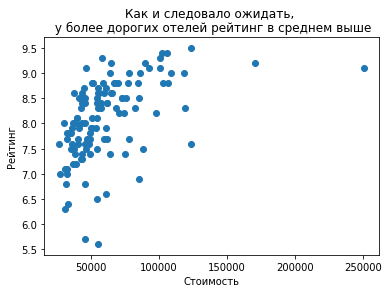

In [15]:
plt.scatter(data.price, data.rating)
plt.xlabel('Стоимость')
plt.ylabel('Рейтинг')
plt.title('Как и следовало ожидать, \n у более дорогих отелей рейтинг в среднем выше');

Теперь найдем Парето-оптимальные отели.

Напомним, что отель называется Парето-оптимальным, если никакой другой отель его не доминирует. 

Мы говорим, что отель A доминирует Б, если A не хуже Б ни по цене, ни по качеству, и хотя бы по одному из параметров А строго лучше. 

In [16]:
optimal = []
# проходим по списку всех отелей по возрастанию цены
for idx, hotel in data.sort_values('price').iterrows():
    # берём все отели, которые не хуже данного по цене и качеству
    better = data[(data.price <= hotel.price) & (data.rating >= hotel.rating)]
    # если ни один из них не строго лучше нашего, то наш - Парето-оптимальный
    if better.price.min() == hotel.price and better.rating.max() == hotel.rating:
        optimal.append(hotel)
optimal = pd.DataFrame(optimal)
optimal

,name,price,rating
83,Jingtailong International Hotel,26985.0,7.6
18,Beijing Prime Hotel Wangfujing,30160.0,8.0
93,Beijing Qianyuan Hotel,37887.0,8.6
17,Beijing Hotel NUO Wangfujing,45401.0,8.7
0,New World Beijing Hotel,46554.0,9.1
52,Shichahai Sandalwood Boutique Hotel Beijing,58181.0,9.3
99,Zhaolin Grand Hotel,102196.0,9.4
57,Rosewood Beijing,123717.0,9.5


Именно эти 8 отелей обеспечивают лучшее соотношение цена-качество. 

Все остальные отели хуже какого-либо из Парето-оптимальных или по цене, или по качеству, или по тому и другому. 

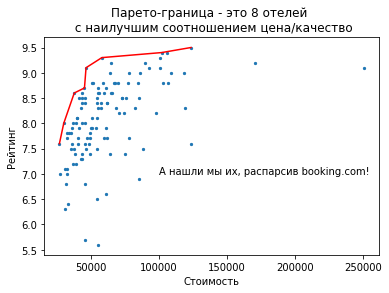

In [24]:
plt.scatter(data.price, data.rating, s=5);
plt.plot(optimal.price, optimal.rating, color = 'red')
plt.xlabel('Стоимость')
plt.ylabel('Рейтинг')
plt.title('Парето-граница - это 8 отелей \n с наилучшим соотношением цена/качество');
plt.text(100000, 7, 'А нашли мы их, распарсив booking.com!');

Напоследок сохраним данные, чтобы этот блокнот стал воспроизводим. 

In [18]:
import pickle
pickle.dump(hotels, open('hotels.pkl', 'wb'))

Удачного вам парсинга, оптимизации, и, конечно, новогодних праздников! До встречи :)